# Initialization

In [1]:
import pandas as pd, numpy as np,xarray as xr
from pathlib import Path
import re, yaml, copy, json
from helper import singleglob, json_merge
import events_methods




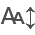

In [2]:
import itables
itables.init_notebook_mode(all_interactive=True )
itables.options.maxBytes = "1MB"
itables.options.lengthMenu = [25, 10, 50, 100, 200]
# itables.options.scrollY="200px"
# itables.options.scrollCollapse=True
# itables.options.paging=False
itables.options.column_filters = "footer"
itables.options.layout={"topEnd": None, "top1": "searchBuilder"}

In [3]:
# base = Path("/home/julienb/Documents/database_scripts/database_scripts_test/poly_dat_files/Rats/Test_Julien_ForcedInput/")
base = Path("/home/julienb/Documents/database_scripts/database_scripts_test/poly_dat_files/Rats/Luisa/Rat101_0729_opto_01")
# base = Path("/home/julienb/Documents/database_scripts/database_scripts_test/poly_dat_files/Humans/BAGOSMOV/EX1/")
dat_path = singleglob(base, "*.dat")
task_path = singleglob(base, "*.xls")
info_path = singleglob(base, "*.yaml", search_upward_limit=Path("/home/julienb/Documents/database_scripts/database_scripts_test/poly_dat_files"))
res_events_path = base/"events.tsv"
info_path

PosixPath('/home/julienb/Documents/database_scripts/database_scripts_test/poly_dat_files/Rats/rat_model.yaml')

# Reading poly events and adding task information 

In [4]:
event_df = pd.read_csv(dat_path, sep="\t", names=['time (ms)', 'family', 'nbre', '_P', '_V', '_L', '_R', '_T', '_W', '_X', '_Y', '_Z'], skiprows=13, dtype=int)
event_df.insert(0, "t", event_df.pop("time (ms)")/1000)
event_df = event_df.reset_index(names="poly_evnum").sort_values(["t", "poly_evnum"]).reset_index(drop=True)
event_df["task_node"] = event_df["_T"].where(event_df["family"]==10).ffill()
event_df

poly_evnum         t  family  nbre  _P  _V  _L  _R   _T   _W   _X   _Y  \
0              0     0.006      10     1   1   1   0   0    1    0    0    0   
1              1     0.023      10     1   1   1   0   0   36    0    0    0   
2              2     0.023       6    22   1   1   1   0    2    1    1    1   
3              3     0.118      10     1   1   1   0   0   38    0    0    0   
4              4     0.128      10     1   1   1   0   0    2    0    0    0   
...          ...       ...     ...   ...  ..  ..  ..  ..  ...  ...  ...  ...   
5745        5745  1175.145       6    22   1   1   1   0  895  843  493  402   
5746        5746  1175.902       5     1   1   1   2   1   62  824    0  763   
5747        5747  1175.902       5     1   1   1   2   1   62  824    0  763   
5748        5748  1176.052       5     1   0   1   2   0   62  825    0  763   
5749        5749  1176.842      11     4   1   1   0   0    0    0    0    0   

      _Z  task_node  
0      0        1.0  
1      0       36.0  
2      0       36.0  
3      0       38.0  
4      0        2.0  
...   ..        ...  
5745   2       45.0  
5746  61       45.0  
5747  61       45.0  
5748  62       45.0  
5749   0       45.0  

[5750 rows x 14 columns]

In [5]:
task_df = pd.read_csv(task_path, sep="\t", header=11)
task_df = task_df.rename(columns={task_df.columns[0]: "task_node" })
display(task_df.columns)
task_df

Index(['task_node', 'T1', 'T2', 'T3', 'T4', 'LED1(1,2)', 'LED2(1,3)',
       'LED3(1,4)', 'L1(2,1)', 'L2(2,2)', 'LK1(5,1)', 'LK2(5,2)', 'RD(6,11)',
       'ASND(6,20)', 'PAD(6,22)', 'STR1(13,1)', 'STR2(13,2)', 'TTLP1(15,1)',
       'TTLP2(15,2)', 'TTLP3(15,3)', 'TTLP4(15,4)', 'TTLP5(15,5)',
       'TTLP6(15,6)', 'TTLP7(15,7)', 'TTLP8(15,8)', 'NEXT1', 'NEXT2', 'NEXT3',
       'CT1', 'CT2'],
      dtype='object')

task_node        T1   T2  T3  T4 LED1(1,2) LED2(1,3) LED3(1,4)  L1(2,1)  \
0           1        10  NaN NaN NaN       NaN       NaN       NaN      NaN   
1           2   _essais  NaN NaN NaN       !on       !on       !on      NaN   
2           3        70  NaN NaN NaN       !on       !on       !on      NaN   
3           4       100  NaN NaN NaN       NaN       NaN        on      NaN   
4           5  400-1400  NaN NaN NaN       NaN       NaN        on      NaN   
..        ...       ...  ...  ..  ..       ...       ...       ...      ...   
61         62       NaN  NaN NaN NaN       NaN       NaN       NaN      NaN   
62         63       NaN  NaN NaN NaN       NaN       NaN       NaN      NaN   
63         64       NaN  NaN NaN NaN       NaN       NaN       NaN      NaN   
64         65       NaN  NaN NaN NaN       NaN       NaN       NaN      NaN   
65         66       NaN  NaN NaN NaN       NaN       NaN       NaN      NaN   

    L2(2,2)  ... TTLP4(15,4)  TTLP5(15,5)  TTLP6(15,6) TTLP7(15,7)  \
0       NaN  ...         NaN          NaN          NaN         NaN   
1       NaN  ...         NaN          NaN          NaN         NaN   
2       NaN  ...         NaN          NaN          NaN         NaN   
3       NaN  ...         NaN          NaN          NaN         NaN   
4       NaN  ...         NaN          NaN          NaN         NaN   
..      ...  ...         ...          ...          ...         ...   
61      NaN  ...         NaN          NaN          NaN         NaN   
62      NaN  ...         NaN          NaN          NaN         NaN   
63      NaN  ...         NaN          NaN          NaN         NaN   
64      NaN  ...         NaN          NaN          NaN         NaN   
65      NaN  ...         NaN          NaN          NaN         NaN   

    TTLP8(15,8)       NEXT1       NEXT2       NEXT3  CT1  CT2  
0           NaN     !ti(36)         NaN         NaN  NaN  NaN  
1           NaN     PAD_L=1  L1_L=1(28)  L2_L=1(26)  NaN  NaN  
2           NaN  PAD_L=0(2)         !ti         NaN  NaN  NaN  
3           NaN  PAD_L=0(2)         !ti         NaN  NaN  NaN  
4           NaN  PAD_L=0(2)         !ti         NaN  NaN  NaN  
..          ...         ...         ...         ...  ...  ...  
61          NaN         NaN         NaN         NaN  NaN  NaN  
62          NaN         NaN         NaN         NaN  NaN  NaN  
63          NaN         NaN         NaN         NaN  NaN  NaN  
64          NaN         NaN         NaN         NaN  NaN  NaN  
65          NaN         NaN         NaN         NaN  NaN  NaN  

[66 rows x 30 columns]

In [6]:


channels = pd.Series(task_df.columns).str.extract(r'\s*(?P<channel_name>\w+)\s*\((?P<family>\d+)\s*,\s*(?P<nbre>\d+)\)\s*').assign(taskcol_name=task_df.columns).dropna(how="any")
channels["family"] = channels["family"].astype(int)
channels["nbre"] = channels["nbre"].astype(int)
channels

    

channel_name  family  nbre taskcol_name
5          LED1       1     2    LED1(1,2)
6          LED2       1     3    LED2(1,3)
7          LED3       1     4    LED3(1,4)
8            L1       2     1      L1(2,1)
9            L2       2     2      L2(2,2)
10          LK1       5     1     LK1(5,1)
11          LK2       5     2     LK2(5,2)
12           RD       6    11     RD(6,11)
13         ASND       6    20   ASND(6,20)
14          PAD       6    22    PAD(6,22)
15         STR1      13     1   STR1(13,1)
16         STR2      13     2   STR2(13,2)
17        TTLP1      15     1  TTLP1(15,1)
18        TTLP2      15     2  TTLP2(15,2)
19        TTLP3      15     3  TTLP3(15,3)
20        TTLP4      15     4  TTLP4(15,4)
21        TTLP5      15     5  TTLP5(15,5)
22        TTLP6      15     6  TTLP6(15,6)
23        TTLP7      15     7  TTLP7(15,7)
24        TTLP8      15     8  TTLP8(15,8)

In [7]:
pattern=r'on\(\d+(,\d+)*\)'
task_info=pd.DataFrame()
stacked = task_df.set_index("task_node")[channels["taskcol_name"].to_list()].stack().str.lower().str.strip().dropna()
stacked.index.names=["task_node", "taskcol_name"]
task_info["data"] = stacked
task_info["match"] = task_info["data"].str.fullmatch(pattern)
task_info = task_info.loc[task_info["match"]]
task_info["important"] = task_info["data"].str.slice(3, -1)
task_info["task_params"] = task_info["important"].str.split(",").apply(lambda l: [float(x) for x in l])
task_info = task_info.drop(columns=["important", "match", "data"]).join(stacked.rename("task_data"), how="outer")
task_info = task_info.reset_index() 
task_info["task_node"] = task_info["task_node"].astype(float)
task_info


task_node taskcol_name task_params task_data
0          2.0    LED1(1,2)         NaN       !on
1          2.0    LED2(1,3)         NaN       !on
2          2.0    LED3(1,4)         NaN       !on
3          3.0    LED1(1,2)         NaN       !on
4          3.0    LED2(1,3)         NaN       !on
..         ...          ...         ...       ...
112       49.0    LED2(1,3)         NaN        on
113       49.0    LED3(1,4)         NaN        on
114       49.0  TTLP4(15,4)         NaN       !on
115       49.0  TTLP7(15,7)     [300.0]   on(300)
116       49.0  TTLP8(15,8)         NaN       !on

[117 rows x 4 columns]

In [8]:
event_channels_df = channels.merge(event_df, on=["family", "nbre"], how="right").merge(task_info, on=["taskcol_name", "task_node"], how="left").sort_values("t")
event_channels_df

channel_name  family  nbre taskcol_name  poly_evnum         t  _P  _V  \
0             NaN      10     1          NaN           0     0.006   1   1   
1             NaN      10     1          NaN           1     0.023   1   1   
2             PAD       6    22    PAD(6,22)           2     0.023   1   1   
3             NaN      10     1          NaN           3     0.118   1   1   
5             NaN      10     1          NaN           5     0.128   1   1   
...           ...     ...   ...          ...         ...       ...  ..  ..   
5745          PAD       6    22    PAD(6,22)        5745  1175.145   1   1   
5746          LK1       5     1     LK1(5,1)        5746  1175.902   1   1   
5747          LK1       5     1     LK1(5,1)        5747  1175.902   1   1   
5748          LK1       5     1     LK1(5,1)        5748  1176.052   0   1   
5749          NaN      11     4          NaN        5749  1176.842   1   1   

      _L  _R   _T   _W   _X   _Y  _Z  task_node task_params task_data  
0      0   0    1    0    0    0   0        1.0         NaN       NaN  
1      0   0   36    0    0    0   0       36.0         NaN       NaN  
2      1   0    2    1    1    1   0       36.0         NaN       NaN  
3      0   0   38    0    0    0   0       38.0         NaN       NaN  
5      0   0    3    0    0    0   0        3.0         NaN       NaN  
...   ..  ..  ...  ...  ...  ...  ..        ...         ...       ...  
5745   1   0  895  843  493  402   2       45.0         NaN       NaN  
5746   2   1   62  824    0  763  61       45.0       [2.0]     on(2)  
5747   2   1   62  824    0  763  61       45.0       [2.0]     on(2)  
5748   2   0   62  825    0  763  62       45.0       [2.0]     on(2)  
5749   0   0    0    0    0    0   0       45.0         NaN       NaN  

[5750 rows x 18 columns]

# Extracting configuration information

In [9]:
info = yaml.safe_load(info_path.open("r"))


In [10]:
event_spec = events_methods.FiberEventProcessing.process_info(channels["channel_name"].to_list(), info["processing"])
pd.DataFrame(list(event_spec.values()))


event_name                          method  \
0                  LED1              output_binary_wave   
1                  LED2              output_binary_wave   
2                  LED3              output_binary_wave   
3                 TTLP1              output_binary_wave   
4                 TTLP2              output_binary_wave   
5                 TTLP3              output_binary_wave   
6                 TTLP4              output_binary_wave   
7                 TTLP5              output_binary_wave   
8                 TTLP6              output_binary_wave   
9                 TTLP7              output_binary_wave   
10                TTLP8              output_binary_wave   
11                 ASND              output_binary_wave   
12                   L1               input_binary_wave   
13                   L2               input_binary_wave   
14                PAD_P               input_binary_wave   
15                PAD_V               input_binary_wave   
16             LK1_lick               input_binary_wave   
17             LK2_lick               input_binary_wave   
18           LK1_reward  output_accumulator_binary_wave   
19           LK2_reward  output_accumulator_binary_wave   
20  polytask_linechange                       step_wave   
21          zone_change                       step_wave   
22                   RD                     event_pulse   
23                pause                     event_pulse   

                                        method_params  \
0   {'filter_expr': 'channel_name=="LED1"', 'state...   
1   {'filter_expr': 'channel_name=="LED2"', 'state...   
2   {'filter_expr': 'channel_name=="LED3"', 'state...   
3   {'filter_expr': 'channel_name=="TTLP1"', 'stat...   
4   {'filter_expr': 'channel_name=="TTLP2"', 'stat...   
5   {'filter_expr': 'channel_name=="TTLP3"', 'stat...   
6   {'filter_expr': 'channel_name=="TTLP4"', 'stat...   
7   {'filter_expr': 'channel_name=="TTLP5"', 'stat...   
8   {'filter_expr': 'channel_name=="TTLP6"', 'stat...   
9   {'filter_expr': 'channel_name=="TTLP7"', 'stat...   
10  {'filter_expr': 'channel_name=="TTLP8"', 'stat...   
11  {'filter_expr': 'channel_name=="ASND"', 'state...   
12  {'filter_expr': 'channel_name=="L1"', 'state_e...   
13  {'filter_expr': 'channel_name=="L2"', 'state_e...   
14  {'filter_expr': 'channel_name=="PAD"', 'state_...   
15  {'filter_expr': 'channel_name=="PAD"', 'state_...   
16  {'filter_expr': 'channel_name=="LK1"', 'state_...   
17  {'filter_expr': 'channel_name=="LK2"', 'state_...   
18  {'filter_expr': 'channel_name=="LK1"', 'state_...   
19  {'filter_expr': 'channel_name=="LK2"', 'state_...   
20  {'filter_expr': 'family==10', 'state_expr': '_T'}   
21   {'filter_expr': 'family==9', 'state_expr': '_X'}   
22              {'filter_expr': 'channel_name=="RD"'}   
23                      {'filter_expr': 'family==11'}   

                                             metadata  
0                                                 NaN  
1                                                 NaN  
2                                                 NaN  
3                                                 NaN  
4                                                 NaN  
5                                                 NaN  
6                                                 NaN  
7                                                 NaN  
8                                                 NaN  
9                                                 NaN  
10                                                NaN  
11  {'volume_expr': 'task[3]', 'frequency_expr': '...  
12                                                NaN  
13                                                NaN  
14                                                NaN  
15                                                NaN  
16                                                NaN  
17                                                NaN  
18                                             

# Running event extraction methods

In [11]:
event_channels_df = event_channels_df.sort_values(["t", "poly_evnum"])
all=[]
for ev_name, item in event_spec.items():
    ev_dataframe = events_methods.PolyEventProcessing.compute_evdataframe(event_channels_df, item)
    if len(ev_dataframe.index) == 0: continue
    events = events_methods.PolyEventProcessing.call(item["method"],ev_dataframe, item)
    all.append(events.reset_index(drop=True))

all = pd.concat(all).sort_values("t")
all
  

event_name         t  duration  n_segments      metadata  \
0    polytask_linechange     0.006     0.017         1.0            {}   
0                  PAD_V     0.023    12.411         1.0            {}   
0                  PAD_P     0.023    12.245         1.0            {}   
1    polytask_linechange     0.023     0.095         1.0            {}   
2    polytask_linechange     0.118     0.010         1.0            {}   
..                   ...       ...       ...         ...           ...   
491                PAD_P  1174.757     0.358         1.0            {}   
401                PAD_V  1174.940       NaN         1.0          None   
492                PAD_P  1175.145       NaN         1.0          None   
111             LK1_lick  1175.902       NaN         1.0          None   
0                  pause  1176.842       NaN         0.0  {'cause': 1}   

    waveform_changes  waveform_values  
0                [0]   [nan, 1, 36.0]  
0                [0]        [0, 1, 0]  
0                [0]        [0, 1, 0]  
1                [0]  [1.0, 36, 38.0]  
2                [0]  [36.0, 38, 2.0]  
..               ...              ...  
491              [0]        [0, 1, 0]  
401              [0]        [0, 1, 0]  
492              [0]        [0, 1, 0]  
111              [0]        [0, 1, 0]  
0                NaN              NaN  

[2846 rows x 7 columns]

# Renaming and exporting, displaying reload

In [12]:
if "display" in info and "rename" in info["display"]:
    all["event_name"] = all["event_name"].map(lambda e: info["display"]["rename"][e] if e in info["display"]["rename"] else e)
json_cols = ["metadata", "waveform_changes", "waveform_values"]
for col in json_cols:
    all[f"{col}_json"] = all[col].apply(lambda d: json.dumps(d))
all.drop(columns=json_cols).to_csv(res_events_path, sep="\t", index=False)
reloaded = pd.read_csv(res_events_path, sep="\t", index_col=False)
for col in reloaded.columns:
    if col.endswith("_json"):
        reloaded[col[:-5]] = reloaded.pop(col).apply(lambda s: json.loads(s) if not pd.isna(s) else None)
reloaded

event_name         t  duration  n_segments      metadata  \
0     polytask_linechange     0.006     0.017         1.0            {}   
1               PAD_right     0.023    12.411         1.0            {}   
2                PAD_left     0.023    12.245         1.0            {}   
3     polytask_linechange     0.023     0.095         1.0            {}   
4     polytask_linechange     0.118     0.010         1.0            {}   
...                   ...       ...       ...         ...           ...   
2841             PAD_left  1174.757     0.358         1.0            {}   
2842            PAD_right  1174.940       NaN         1.0          None   
2843             PAD_left  1175.145       NaN         1.0          None   
2844             LK1_lick  1175.902       NaN         1.0          None   
2845                pause  1176.842       NaN         0.0  {'cause': 1}   

     waveform_changes  waveform_values  
0                 [0]   [nan, 1, 36.0]  
1                 [0]        [0, 1, 0]  
2                 [0]        [0, 1, 0]  
3                 [0]  [1.0, 36, 38.0]  
4                 [0]  [36.0, 38, 2.0]  
...               ...              ...  
2841              [0]        [0, 1, 0]  
2842              [0]        [0, 1, 0]  
2843              [0]        [0, 1, 0]  
2844              [0]        [0, 1, 0]  
2845             None             None  

[2846 rows x 7 columns]

# Summary Information (Checks)

In [13]:
summary = reloaded.copy()

def compute_grp(duration):
    n = len(duration.index)
    rounded = np.round(duration*100)/100
    counts = rounded.value_counts()
    important = (counts > 2) & (counts > n/5)
    important_min_val = counts.loc[important].index.min()
    important_max_val = counts.loc[important].index.max()
    ret = np.where(rounded.map(important), rounded, 
          np.where(duration<important_min_val, f"{rounded.min()}<=v<{important_min_val}", 
          np.where(duration>important_max_val, f"{important_max_val}<v<={rounded.max()}", 
          "_"
        )))
    
    return ret


summary["duration_goup"]= summary.groupby(["event_name", "n_segments"])["duration"].transform(compute_grp)
summary["metadata"].iat[0] = dict(warnings=dict(test="2", other="3"))
warning_list = summary["metadata"].apply(lambda d: list(d["warnings"].keys()) if not d is None and "warnings"in d else [])
all_warnings = set(warning_list.sum())

def compute_info(grp):
    warnings = {k: 0 for k in all_warnings}
    for m in grp["metadata"].values:
        if m is None: continue
        if "warnings" in m:
            for k in m["warnings"].keys():
                if not k in warnings:
                    warnings[k]=0
                warnings[k]+=1
    return pd.Series(dict(n=len(grp.index)) | {f'warning_{k}': v for k, v in warnings.items()})
summary.groupby(["event_name", "n_segments", "duration_goup"]).apply(compute_info, include_groups=False).reset_index()

event_name  n_segments duration_goup     n  warning_test  \
0                  ASND         1.0          0.05    50             0   
1                  ASND         1.0           0.3    13             0   
2                  LED1         1.0          0.05    50             0   
3                  LED1         1.0           2.0    36             0   
4                  LED2         1.0           2.0    36             0   
5                  LED3         1.0    0.0<=v<2.0   121             0   
6                  LED3         1.0           2.0    36             0   
7            LEVER_left         1.0             _    42             0   
8              LK1_lick         1.0             _   111             0   
9              LK1_lick         1.0           nan     1             0   
10           LK1_reward         2.0           1.0    31             0   
11             PAD_left         1.0             _   492             0   
12             PAD_left         1.0           nan     1             0   
13            PAD_right         1.0             _   401             0   
14            PAD_right         1.0           nan     1             0   
15                TTLP1         1.0           0.1    63             0   
16                TTLP2         1.0          0.04    15             0   
17                TTLP2         1.0   0.0<=v<0.04     2             0   
18                TTLP2         1.0           0.1    17             0   
19                TTLP2         1.0          0.15    13             0   
20                TTLP2         1.0           0.2    16             0   
21                TTLP3         1.0          0.05    32             0   
22                TTLP3         1.0           0.3    13             0   
23                TTLP3         2.0          0.15    18             0   
24                TTLP4         1.0   0.12<=v<1.0     8             0   
25                TTLP4         1.0           1.0     8             0   
26                TTLP5         1.0          0.04    16             0   
27                TTLP5         1.0           0.1    18             0   
28                TTLP5         1.0           0.2    16             0   
29                TTLP6         1.0          0.04     8             0   
30                TTLP6         1.0          0.15    12             0   
31                TTLP6         1.0           0.2     9             0   
32                TTLP6         1.0             _     2             0   
33                TTLP7         1.0   0.15<=v<0.3     4             0   
34                TTLP7         1.0           0.3    32             0   
35                TTLP8         1.0   0.12<=v<1.0     8             0   
36                TTLP8         1.0           1.0     8             0   
37                pause         0.0           nan     1             0   
38  polytask_linechange         1.0             _  1083             1   
39  polytask_linechange         1.0           nan     1             0   
40          zone_change         1.0           nan     1             0   

    warning_other  warning_duration_correction  
0               0                            0  
1               0                            0  
2               0                            0  
3               0                            0  
4               0                            0  
5               0                            0  
6               0                            0  
7               0                            0  
8               0                            0  
9               0                            0  
10              0                            0  
11              0                            0  
12              0                            0  
13              0                            0  
14              0                            0  
15              0                            0  
16              0                           15  
17              0                            0  
18             